In [1]:
import pandas as pd
import numpy as np 
import itertools
import keras
import tensorflow as tf


from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from tensorflow.keras.models import Sequential 
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dropout, Flatten, Dense 
from tensorflow.keras import applications 
from keras.utils.np_utils import to_categorical


import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math 
import datetime
import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Default dimensions we found online
img_width, img_height = 224, 224 
 
#Create a bottleneck file
top_model_weights_path = 'bottleneck_fc_model.h5'


# loading up our datasets
train_data_dir = 'C:/Users/arman/OneDrive/School/Spring 2022/ML/Final Project/blood cell dataset/dataset2-master/dataset2-master/images/TRAIN'
validation_data_dir = "C:/Users/arman/OneDrive/School/Spring 2022/ML/Final Project/blood cell dataset/dataset2-master/dataset2-master/images/VAL"
test_data_dir = "C:/Users/arman/OneDrive/School/Spring 2022/ML/Final Project/blood cell dataset/dataset2-master/dataset2-master/images/TEST"
 
# number of epochs to train top model 

# batch size used by flow_from_directory and predict_generator 
batch_size = 50

In [3]:
# Loading vgc16 model
# Here we're making use of transfer learning!? This is a great tool to make use of when building CNN. We can make use of a prebuilt model to help provide some foundation to our model.

vgg16 = applications.VGG16(include_top=False, weights='imagenet')
datagen = ImageDataGenerator(rescale=1. / 255) # needed to create the bottleneck .npy files

In [4]:
# Loading resnet50 model
# Here we're making use of transfer learning!? This is a great tool to make use of when building CNN. We can make use of a prebuilt model to help provide some foundation to our model.

# resnet50 = applications.ResNet50V2(include_top=False, weights='imagenet')
# datagen = ImageDataGenerator(rescale=1. / 255) # needed to create the bottleneck .npy files

# RUNNING OUT OF MEMORY (OOM) WHEN USING RESNET50V2 AND AN RTX 3070!? What!?

In [5]:
# TRAINING HERE - making use of transfer training to create our .npy files for our data preparation below

start = datetime.datetime.now()
 
generator = datagen.flow_from_directory( 
    train_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode=None, 
    shuffle=False) 
 
nb_train_samples = len(generator.filenames) 
num_classes = len(generator.class_indices) 
 
predict_size_train = int(math.ceil(nb_train_samples / batch_size)) 
 
bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train)
# bottleneck_features_train = resnet50.predict_generator(generator, predict_size_train) 
 
np.save('bottleneck_features_train.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 9957 images belonging to 4 classes.
Time:  0:00:26.516025


In [6]:
# TESTING HERE - making use of transfer training to create our .npy files for our data preparation below

start = datetime.datetime.now()
 
generator = datagen.flow_from_directory( 
    test_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode=None, 
    shuffle=False) 
 
nb_test_samples = len(generator.filenames) 
num_classes = len(generator.class_indices) 
 
predict_size_test = int(math.ceil(nb_test_samples / batch_size)) 
 
bottleneck_features_test = vgg16.predict_generator(generator, predict_size_test)
# bottleneck_features_test = resnet50.predict_generator(generator, predict_size_test) 
 
np.save('bottleneck_features_test.npy', bottleneck_features_test)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 2007 images belonging to 4 classes.
Time:  0:00:04.336129


In [7]:
# VALIDATION HERE - making use of transfer training to create our .npy files for our data preparation below

start = datetime.datetime.now()
 
generator = datagen.flow_from_directory( 
    validation_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode=None, 
    shuffle=False) 
 
nb_val_samples = len(generator.filenames) 
num_classes = len(generator.class_indices) 
 
predict_size_val = int(math.ceil(nb_val_samples / batch_size)) 
 
bottleneck_features_val = vgg16.predict_generator(generator, predict_size_val)
# bottleneck_features_val = resnet50.predict_generator(generator, predict_size_val) 
 
np.save('bottleneck_features_val.npy', bottleneck_features_val)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 480 images belonging to 4 classes.
Time:  0:00:03.005722


In [8]:
# TRAINING DATA - preparing our training data for our CNN below

generator_top = datagen.flow_from_directory( 
   train_data_dir, 
   target_size=(img_width, img_height), 
   batch_size=batch_size, 
   class_mode='categorical', 
   shuffle=False) 
 
nb_train_samples = len(generator_top.filenames) 
num_classes = len(generator_top.class_indices) 
 
# load the bottleneck features saved earlier 
train_data = np.load('bottleneck_features_train.npy') 
 
# get the class labels for the training data, in the original order 
train_labels = generator_top.classes
 
# convert the training labels to categorical vectors 
train_labels = to_categorical(train_labels, num_classes=num_classes)

print(len(train_labels))
print(len(train_data))

Found 9957 images belonging to 4 classes.
9957
9957


In [9]:
# TESTING DATA - preparing our testing data for our CNN below

generator_top = datagen.flow_from_directory( 
   test_data_dir, 
   target_size=(img_width, img_height), 
   batch_size=batch_size, 
   class_mode='categorical', 
   shuffle=False) 
 
nb_test_samples = len(generator_top.filenames) 
num_classes = len(generator_top.class_indices) 
 
# load the bottleneck features saved earlier 
test_data = np.load('bottleneck_features_test.npy') 
 
# get the class labels for the testing data, in the original order 
test_labels = generator_top.classes 
 
# convert the testing labels to categorical vectors 
test_labels = to_categorical(test_labels, num_classes=num_classes)

print(len(test_labels))
print(len(test_data))

Found 2007 images belonging to 4 classes.
2007
2007


In [10]:
# VALIDATION - preparing our validation data for our CNN below

generator_top = datagen.flow_from_directory( 
   validation_data_dir, 
   target_size=(img_width, img_height), 
   batch_size=batch_size, 
   class_mode='categorical', 
   shuffle=False) 
 
nb_val_samples = len(generator_top.filenames) 
num_classes = len(generator_top.class_indices) 
 
# load the bottleneck features saved earlier 
val_data = np.load('bottleneck_features_val.npy') 
 
# get the class labels for the validation data, in the original order 
val_labels = generator_top.classes 
 
# convert the validation labels to categorical vectors 
val_labels = to_categorical(val_labels, num_classes=num_classes)

print(len(val_labels))
print(len(val_data))

Found 480 images belonging to 4 classes.
480
480


In [11]:
# Setting up callback for the different models below
# EarlyStopping with patience 3 allows Keras to stop at an epoch count within the epoch count given- 100- when the accuracy of a given epoch doesn't improve after at least 3 epochs

callback = tf.keras.callbacks.EarlyStopping(monitor = "acc", patience = 3)

### Base Model

Epoch 1/100
312/312 [==============================] - 2s 4ms/step - loss: 1.2858 - acc: 0.4121 - val_loss: 1.1470 - val_acc: 0.4583
Epoch 2/100
312/312 [==============================] - 1s 4ms/step - loss: 0.9679 - acc: 0.5972 - val_loss: 1.0163 - val_acc: 0.5708
Epoch 3/100
312/312 [==============================] - 1s 3ms/step - loss: 0.7766 - acc: 0.6928 - val_loss: 1.0707 - val_acc: 0.5437
Epoch 4/100
312/312 [==============================] - 1s 3ms/step - loss: 0.6403 - acc: 0.7449 - val_loss: 1.1039 - val_acc: 0.5667
Epoch 5/100
312/312 [==============================] - 1s 3ms/step - loss: 0.5497 - acc: 0.7874 - val_loss: 1.1968 - val_acc: 0.5312
Epoch 6/100
312/312 [==============================] - 1s 3ms/step - loss: 0.4624 - acc: 0.8227 - val_loss: 1.6411 - val_acc: 0.4938
Epoch 7/100
312/312 [==============================] - 1s 3ms/step - loss: 0.4085 - acc: 0.8478 - val_loss: 1.1411 - val_acc: 0.5604
Epoch 8/100
312/312 [==============================] - 1s 3ms/step - 

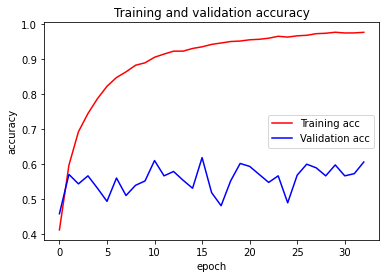

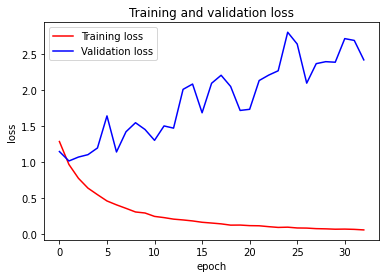

In [12]:
# This is our base model!

start = datetime.datetime.now()

modelBase = Sequential()

modelBase.add(Flatten(input_shape=train_data.shape[1:])) 
modelBase.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3))) 
modelBase.add(Dropout(0.5)) 
modelBase.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3))) 
modelBase.add(Dropout(0.3)) 
modelBase.add(Dense(num_classes, activation='softmax'))


modelBase.compile(optimizer = optimizers.RMSprop(lr=1e-4), loss='categorical_crossentropy', metrics=['acc'])


model_output = modelBase.fit(train_data, train_labels, epochs=100, batch_size=32, callbacks = [callback], validation_data=(val_data, val_labels))


modelBase.save_weights(top_model_weights_path)


(eval_loss, eval_accuracy) = modelBase.evaluate(val_data, val_labels) #, batch_size=32, verbose=1)


print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))
print("[INFO] EarlyStopping Epoch Count:", len(model_output.history["acc"]))


end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)


# Graphing our training and validation

acc = model_output.history['acc']
val_acc = model_output.history['val_acc']
loss = model_output.history['loss']
val_loss = model_output.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

### 4 Hidden Layer CNN

Epoch 1/100
312/312 [==============================] - 2s 5ms/step - loss: 1.2654 - acc: 0.4153 - val_loss: 1.1484 - val_acc: 0.4437
Epoch 2/100
312/312 [==============================] - 2s 5ms/step - loss: 0.9238 - acc: 0.6107 - val_loss: 1.0693 - val_acc: 0.5646
Epoch 3/100
312/312 [==============================] - 2s 5ms/step - loss: 0.7016 - acc: 0.7203 - val_loss: 1.0595 - val_acc: 0.5979
Epoch 4/100
312/312 [==============================] - 2s 5ms/step - loss: 0.5699 - acc: 0.7771 - val_loss: 2.2349 - val_acc: 0.3187
Epoch 5/100
312/312 [==============================] - 2s 5ms/step - loss: 0.4787 - acc: 0.8151 - val_loss: 1.7639 - val_acc: 0.4354
Epoch 6/100
312/312 [==============================] - 2s 5ms/step - loss: 0.3997 - acc: 0.8514 - val_loss: 2.1661 - val_acc: 0.4667
Epoch 7/100
312/312 [==============================] - 2s 5ms/step - loss: 0.3510 - acc: 0.8662 - val_loss: 1.4056 - val_acc: 0.5813
Epoch 8/100
312/312 [==============================] - 2s 5ms/step - 

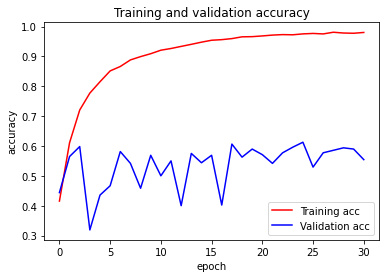

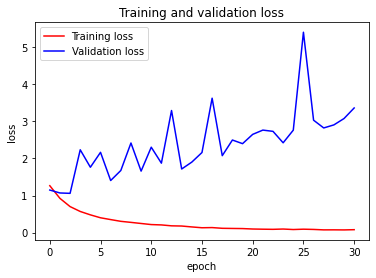

In [13]:
# This is a new variant of our base model! We're going to add some extra layers here!

start = datetime.datetime.now()

model4 = Sequential()

model4.add(Flatten(input_shape=train_data.shape[1:])) 
model4.add(Dense(256, activation=keras.layers.LeakyReLU(alpha=0.3))) 
model4.add(Dropout(0.2)) 
model4.add(Dense(128, activation=keras.layers.LeakyReLU(alpha=0.3))) 
model4.add(Dropout(0.2))
model4.add(Dense(64, activation=keras.layers.LeakyReLU(alpha=0.3)))
model4.add(Dropout(0.2))
model4.add(Dense(32, activation=keras.layers.LeakyReLU(alpha=0.3))) 
model4.add(Dropout(0.2))

model4.add(Dense(num_classes, activation='softmax'))



model4.compile(optimizer = optimizers.RMSprop(lr=1e-4), loss='categorical_crossentropy', metrics=['acc'])


model_output = model4.fit(train_data, train_labels, epochs=100, batch_size=32, callbacks = [callback], validation_data=(val_data, val_labels))


model4.save_weights(top_model_weights_path)


(eval_loss, eval_accuracy) = model4.evaluate(val_data, val_labels) # , batch_size=32, verbose=1)


print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))
print("[INFO] EarlyStopping Epoch Count:", len(model_output.history["acc"]))


end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)


# Graphing our training and validation

acc = model_output.history['acc']
val_acc = model_output.history['val_acc']
loss = model_output.history['loss']
val_loss = model_output.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

#### 5 Hidden Layer CNN

Epoch 1/100
312/312 [==============================] - 2s 6ms/step - loss: 1.3370 - acc: 0.3502 - val_loss: 1.2187 - val_acc: 0.4437
Epoch 2/100
312/312 [==============================] - 2s 5ms/step - loss: 1.0965 - acc: 0.5291 - val_loss: 1.3246 - val_acc: 0.4458
Epoch 3/100
312/312 [==============================] - 2s 5ms/step - loss: 0.8706 - acc: 0.6445 - val_loss: 1.2412 - val_acc: 0.4833
Epoch 4/100
312/312 [==============================] - 1s 5ms/step - loss: 0.6854 - acc: 0.7352 - val_loss: 1.4789 - val_acc: 0.4938
Epoch 5/100
312/312 [==============================] - 1s 5ms/step - loss: 0.5682 - acc: 0.7798 - val_loss: 1.1621 - val_acc: 0.5625
Epoch 6/100
312/312 [==============================] - 1s 5ms/step - loss: 0.4743 - acc: 0.8157 - val_loss: 1.2264 - val_acc: 0.5958
Epoch 7/100
312/312 [==============================] - 1s 5ms/step - loss: 0.4177 - acc: 0.8421 - val_loss: 1.4631 - val_acc: 0.5333
Epoch 8/100
312/312 [==============================] - 2s 5ms/step - 

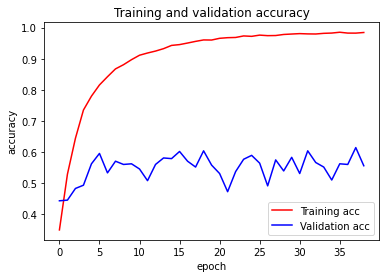

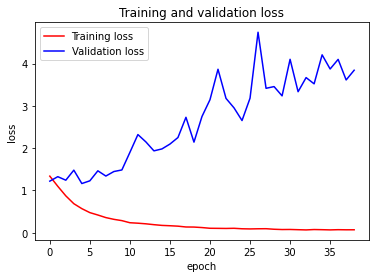

In [16]:
# This is a new variant of our base model! We're going to add some extra layers here!

start = datetime.datetime.now()

model5 = Sequential()

model5.add(Flatten(input_shape=train_data.shape[1:])) 
model5.add(Dense(256, activation=keras.layers.LeakyReLU(alpha=0.3))) 
model5.add(Dropout(0.2)) 
model5.add(Dense(128, activation=keras.layers.LeakyReLU(alpha=0.3))) 
model5.add(Dropout(0.2))
model5.add(Dense(64, activation=keras.layers.LeakyReLU(alpha=0.3)))
model5.add(Dropout(0.2))
model5.add(Dense(32, activation=keras.layers.LeakyReLU(alpha=0.3))) 
model5.add(Dropout(0.2))
model5.add(Dense(16, activation=keras.layers.LeakyReLU(alpha=0.3)))
model5.add(Dropout(0.2))

model5.add(Dense(num_classes, activation='softmax'))



model5.compile(optimizer = optimizers.RMSprop(lr=1e-4), loss='categorical_crossentropy', metrics=['acc'])


model_output = model5.fit(train_data, train_labels, epochs=100, batch_size=32, callbacks = [callback], validation_data=(val_data, val_labels))


model5.save_weights(top_model_weights_path)


(eval_loss, eval_accuracy) = model5.evaluate(val_data, val_labels) # , batch_size=32, verbose=1)


print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))
print("[INFO] EarlyStopping Epoch Count:", len(model_output.history["acc"]))


end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)


# Graphing our training and validation

acc = model_output.history['acc']
val_acc = model_output.history['val_acc']
loss = model_output.history['loss']
val_loss = model_output.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

In [17]:
preds = np.round(model5.predict(test_data), 0)
# print('round test_labels', preds)

bloodcells = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
classification_metrics = metrics.classification_report(test_labels, preds, target_names = bloodcells)
print(classification_metrics)

              precision    recall  f1-score   support

  EOSINOPHIL       0.40      0.50      0.44       503
  LYMPHOCYTE       0.88      0.61      0.72       500
    MONOCYTE       0.51      0.27      0.35       500
  NEUTROPHIL       0.53      0.76      0.62       504

   micro avg       0.54      0.54      0.54      2007
   macro avg       0.58      0.54      0.53      2007
weighted avg       0.58      0.54      0.53      2007
 samples avg       0.54      0.54      0.54      2007



In [18]:
# Converting our data from it's numeric form into a form we can assign predictive labels too!

categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

confusion_matrix = confusion_matrix(categorical_test_labels, categorical_preds)

#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
 
#Add Normalization Option
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
 
# print(cm)
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
       plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


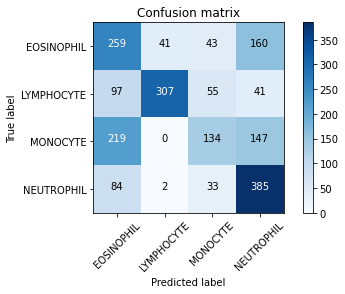

In [19]:
plot_confusion_matrix(confusion_matrix, ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL'], normalize = False)

In [20]:
def read_image(file_path):
   print('[INFO] loading and preprocessing image…') 
   image = load_img(file_path, target_size=(224, 224)) 
   image = img_to_array(image) 
   image = np.expand_dims(image, axis=0)
   image /= 255. 
   return image

def test_single_image(path):
  BC = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
  images = read_image(path)
  time.sleep(.5)
  bt_prediction = vgg16.predict(images) 
  preds = model5.predict(bt_prediction)
  for idx, BCs, x in zip(range(0,6), BC , preds[0]):
   print('ID: {}, Label: {} {}%'.format(idx, BCs, round(x*100,2) ))
  print('Final Decision:')
  time.sleep(.5)
  for x in range(3):
   print('.'*(x+1))
   time.sleep(.2)
  class_predicted = model5.predict(bt_prediction)
  class_dictionary = generator_top.class_indices 
  # inv_map = {v: k for k, v in class_dictionary.items()} 
  # print('ID: {}, Label: {}'.format(class_predicted[0],  inv_map[class_predicted[0]]))
  # print('ID: {}, Label: {}'.format(class_predicted, inv_map))
  return load_img(path)

[INFO] loading and preprocessing image…
ID: 0, Label: EOSINOPHIL 100.0%
ID: 1, Label: LYMPHOCYTE 0.0%
ID: 2, Label: MONOCYTE 0.0%
ID: 3, Label: NEUTROPHIL 0.0%
Final Decision:
.
..
...


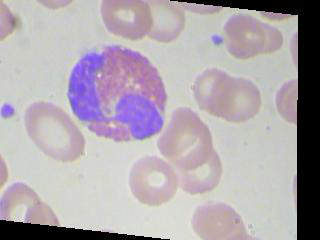

In [21]:
# Testing EOSINOPHIL classification

path = "C:/Users/arman/OneDrive/School/Spring 2022/ML/Final Project/CHECK/EOS.jpeg"
test_single_image(path)

Guessed this was an eosinophile with 100.00% confidence.

[INFO] loading and preprocessing image…
ID: 0, Label: EOSINOPHIL 0.0%
ID: 1, Label: LYMPHOCYTE 100.0%
ID: 2, Label: MONOCYTE 0.0%
ID: 3, Label: NEUTROPHIL 0.0%
Final Decision:
.
..
...


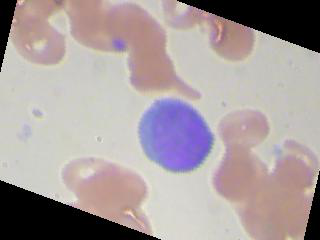

In [22]:
# Testing LYMPHOCYTE classification

path = "C:/Users/arman/OneDrive/School/Spring 2022/ML/Final Project/CHECK/LYMPH.jpeg"
test_single_image(path)

Guessed this was a lymphocyte with 100.00% confidence.

[INFO] loading and preprocessing image…
ID: 0, Label: EOSINOPHIL 1.66%
ID: 1, Label: LYMPHOCYTE 0.0%
ID: 2, Label: MONOCYTE 0.99%
ID: 3, Label: NEUTROPHIL 97.35%
Final Decision:
.
..
...


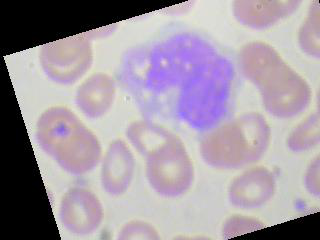

In [23]:
# Testing MONOCYTE classification

path = "C:/Users/arman/OneDrive/School/Spring 2022/ML/Final Project/CHECK/MONO.jpeg"
test_single_image(path)

Guessed this was a monocyte with 31.76% confidence and 56.11% confidence this is an eosinphil. The model clearly has a hard time prediciting the classification of monocytes.

[INFO] loading and preprocessing image…
ID: 0, Label: EOSINOPHIL 0.0%
ID: 1, Label: LYMPHOCYTE 0.0%
ID: 2, Label: MONOCYTE 0.0%
ID: 3, Label: NEUTROPHIL 100.0%
Final Decision:
.
..
...


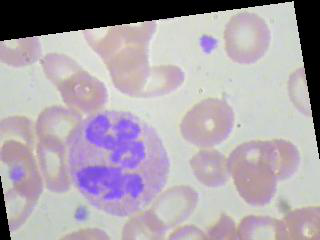

In [24]:
# Testing NEUTROPHIL classification

path = "C:/Users/arman/OneDrive/School/Spring 2022/ML/Final Project/CHECK/NEU.jpeg"
test_single_image(path)

Guessed this image was a neutrophil with 66.86% confidence.